In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Lambda

2025-01-02 19:45:00.495714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 19:45:00.554771: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:45:00.771432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:45:00.885442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735847101.081866    1914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735847101.17

In [13]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])

# split data to train and validation set
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# features 
features = [
    'KielerWoche', 'weekend_or_holiday', 'wetter_sonnig', 'wetter_wolken', 'wetter_regen',
    'wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September',
    'Warengruppe_Broetchen', 'Warengruppe_Brot', 'Warengruppe_Croissant', 'Warengruppe_Konditorei',
    'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 'inflation', 'is_Montag', 'is_Dienstag','is_Mittwoch', 'is_Donnerstag', 'is_Freitag', 'is_Samstag'
]

# target (Umsatz)
target = 'Umsatz'

# scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])# + [target]])
val_scaled = scaler.transform(val_data[features])# + [target]])

scale_factor = 1  # Beispiel: Skaliere Werte hoch


# split feature and target
x_train = train_scaled#[:, :-1]  # all columns except Umsatz
#y_train = train_scaled[:, -1] * scale_factor  # last column: Umsatz
y_train = train_data[target]

x_val = val_scaled#[:, :-1]
#y_val = val_scaled[:, -1] * scale_factor
y_val = val_data[target]

x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [14]:
tf.keras.backend.clear_session()

# create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1),  # Keine Aktivierungsfunktion im Output
    Lambda(lambda x: x * 10)  # Skaliert die Ausgabe um den Faktor 10
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='log_cosh',  # Alternativ: 'Huber' oder 'mse'
    metrics=['mae']
)

# training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

# evaluation
val_loss, val_mae = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')


Epoch 1/50


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 145.5779 - mae: 146.2685 - val_loss: 61.7962 - val_mae: 62.4833 - learning_rate: 0.0010
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48.4878 - mae: 49.1736 - val_loss: 40.8021 - val_mae: 41.4845 - learning_rate: 0.0010
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.9713 - mae: 45.6582 - val_loss: 33.0538 - val_mae: 33.7365 - learning_rate: 0.0010
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.4965 - mae: 45.1815 - val_loss: 38.5774 - val_mae: 39.2657 - learning_rate: 0.0010
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.2241 - mae: 41.9085 - val_loss: 36.3170 - val_mae: 37.0024 - learning_rate: 0.0010
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 43.1596 - mae: 43.8457 - val_loss: 40.3196 - val_mae: 41.0040 - learning_rate: 0.0010
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.1418 - mae: 39.8235 - val_loss: 36.3006 - val_mae: 36.9845 - learning_

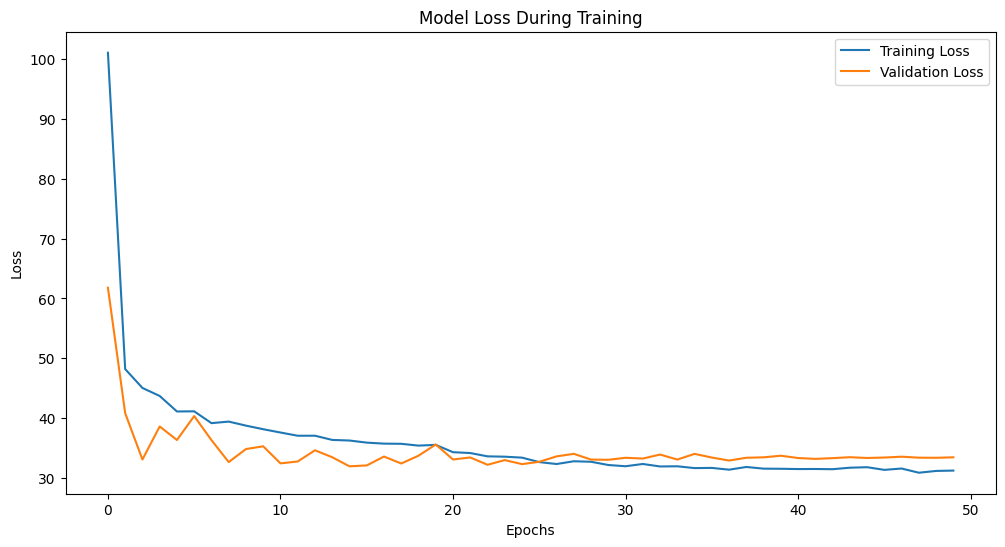

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(x_train) / scale_factor
validation_predictions = model.predict(x_val) / scale_factor
print(f"MAPE on the Training Data: {mape(y_train, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(y_val, validation_predictions):.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 101.22%
MAPE on the Validation Data: 97.34%


In [17]:
# DataFrames für Plots aktualisieren
train_predictions_df = pd.DataFrame({
    'Datum': train_data['Datum'],
    'id': train_data['id'],
    'Tatsächlicher Umsatz': y_train,
    'Vorhergesagter Umsatz': training_predictions.flatten()
})

val_predictions_df = pd.DataFrame({
    'Datum': val_data['Datum'],
    'id': val_data['id'],
    'Tatsächlicher Umsatz': y_val,
    'Vorhergesagter Umsatz': validation_predictions.flatten()
})

In [18]:
train_predictions_df

Datum       id  Tatsächlicher Umsatz  Vorhergesagter Umsatz
0    2013-07-01  1307011            148.828353             159.665359
1    2013-07-02  1307021            159.793757             142.218842
2    2013-07-03  1307031            111.885594             133.616821
3    2013-07-04  1307041            168.864941             150.425583
4    2013-07-05  1307051            171.280754             138.902588
...         ...      ...                   ...                    ...
9273 2016-12-22  1612226             54.322960              74.978241
9274 2016-12-23  1612236            133.499200              80.293076
9275 2016-12-24  1612246             39.577538              62.777042
9276 2016-12-27  1612276             48.890718              56.846619
9277 2016-12-29  1612296             25.998220              74.531723

[7493 rows x 4 columns]

In [20]:

# Mapping für Warengruppen
ware_mapping = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Spalte 'Datum' und 'Warengruppe' extrahieren
train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

# Spalte 'Datum' und 'Warengruppe' extrahieren
val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year


def plot_yearly_sales(df):
    # Liste der Jahre und Warengruppen
    years = sorted(df['Jahr'].unique())
    ware_groups = df['Warengruppe'].unique()

    # Für jedes Jahr und jede Warengruppe aggregieren und plotten
    for year in years:
        for ware_group in ware_groups:
            data = df[(df['Jahr'] == year) & (df['Warengruppe'] == ware_group)]
            
            if data.empty:
                continue
            
            plt.figure(figsize=(12, 6))
            plt.plot(data['Datum'], data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz', marker='o')
            plt.plot(data['Datum'], data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz', marker='x')
            
            plt.title(f'Umsatz für {ware_group} im Jahr {year}')
            plt.xlabel('Datum')
            plt.ylabel('Umsatz')
            plt.legend()
            plt.grid(True)
            
            plt.show()

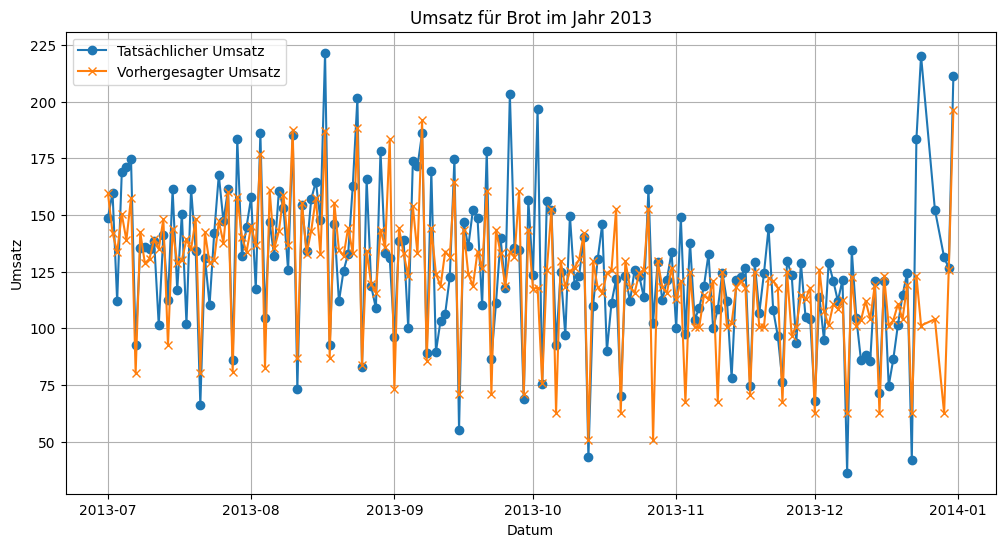

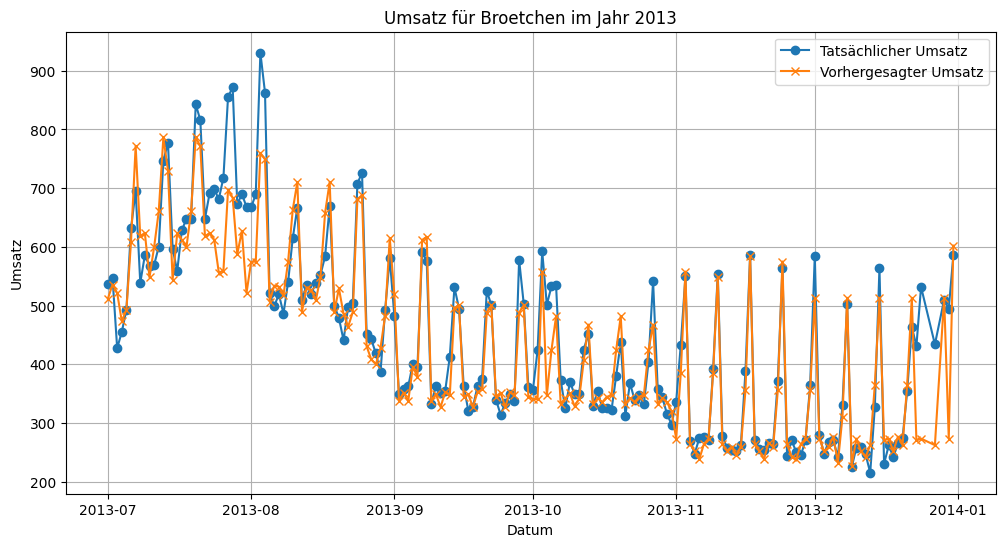

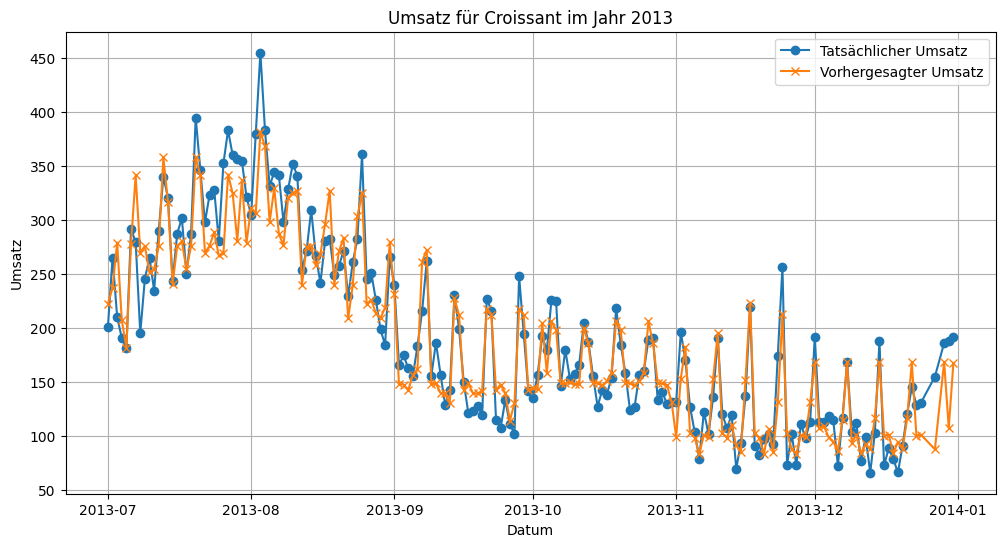

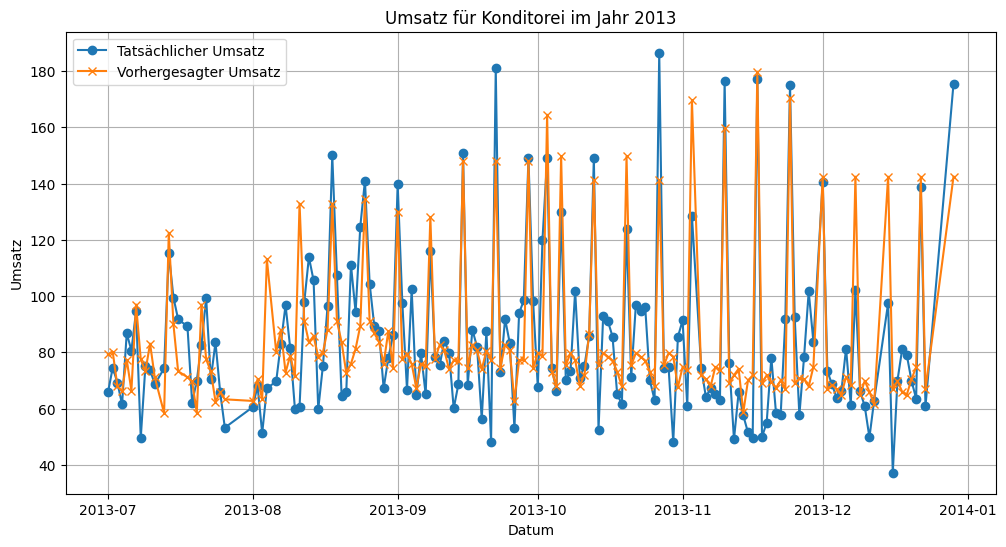

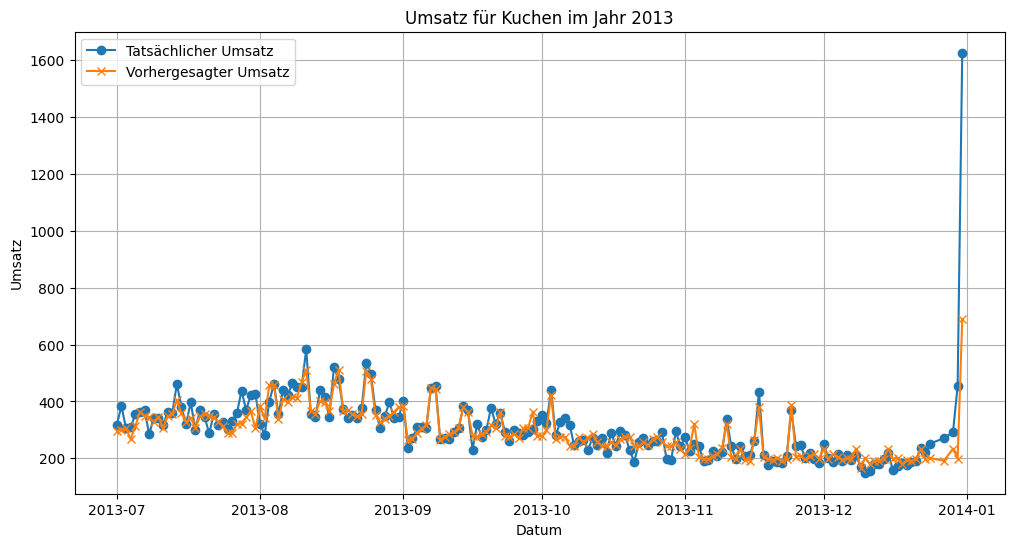

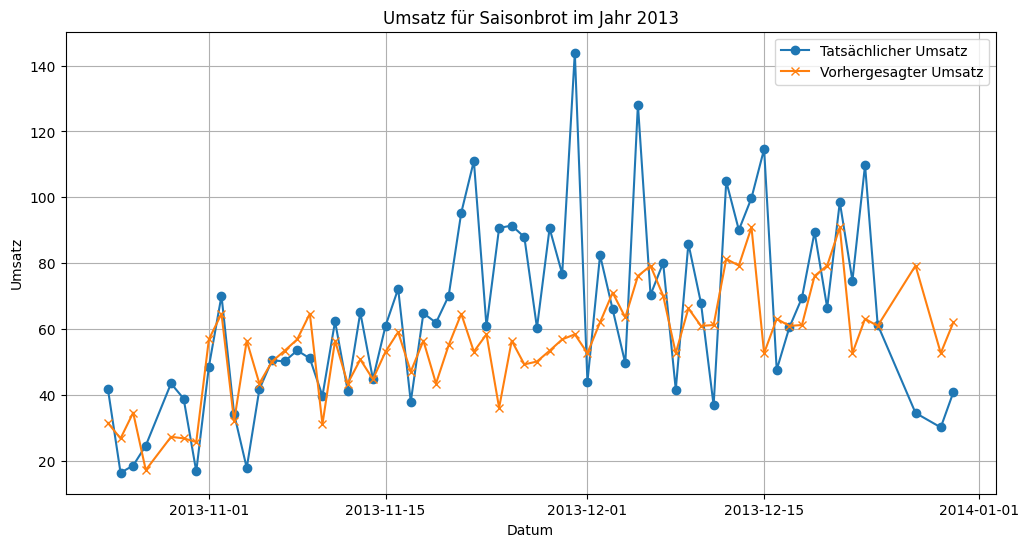

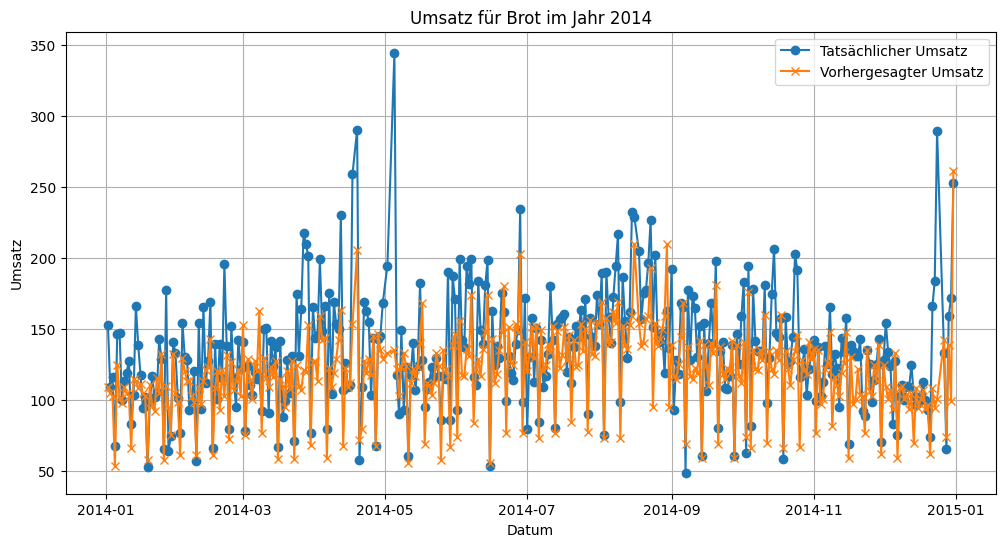

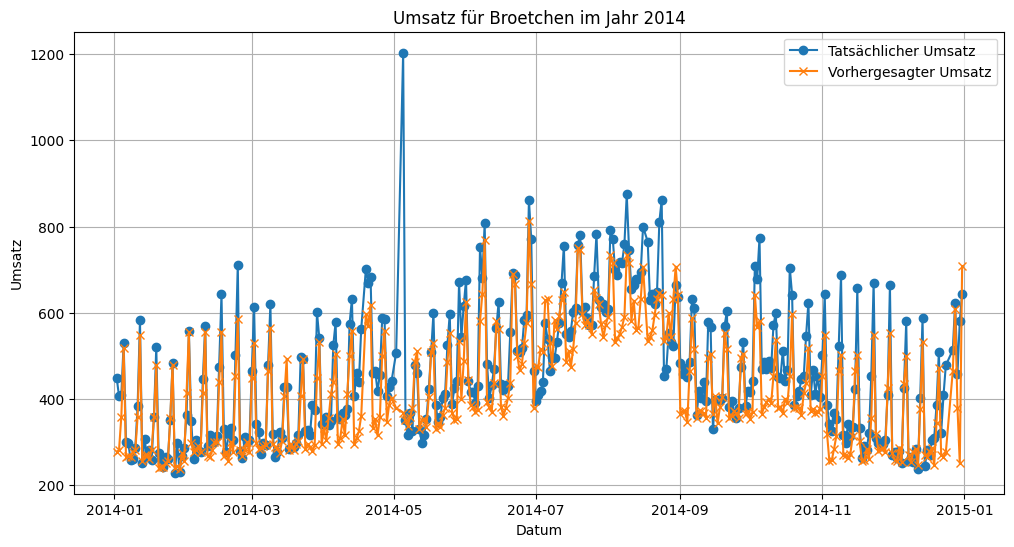

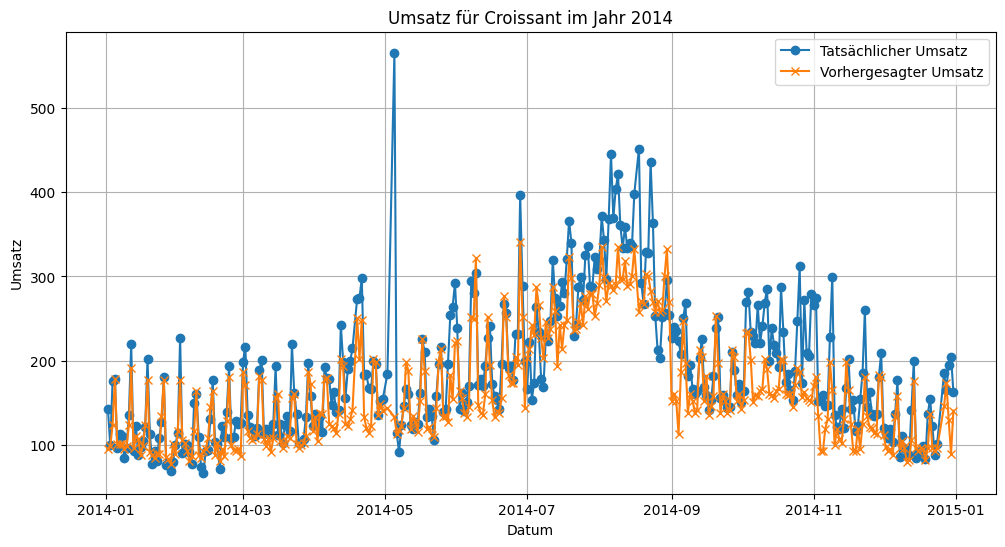

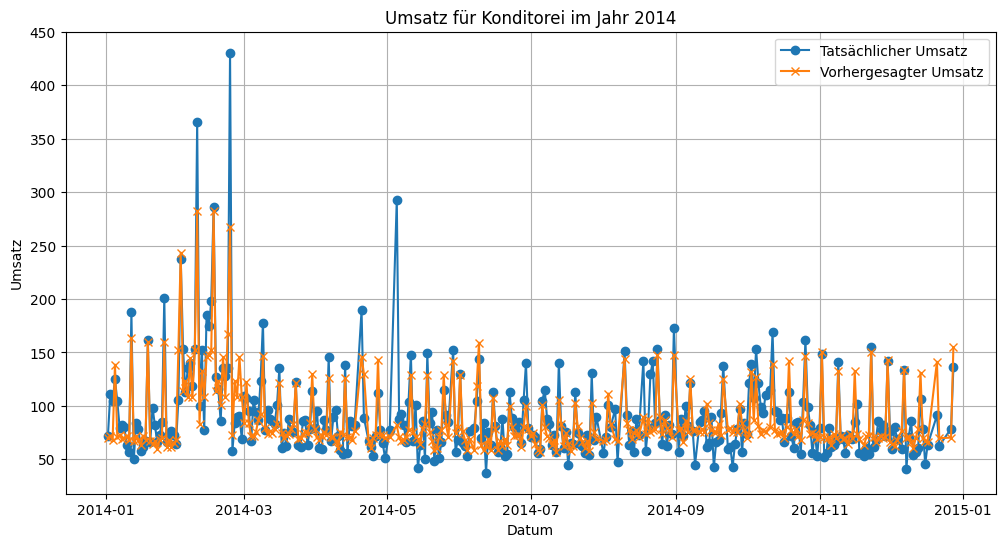

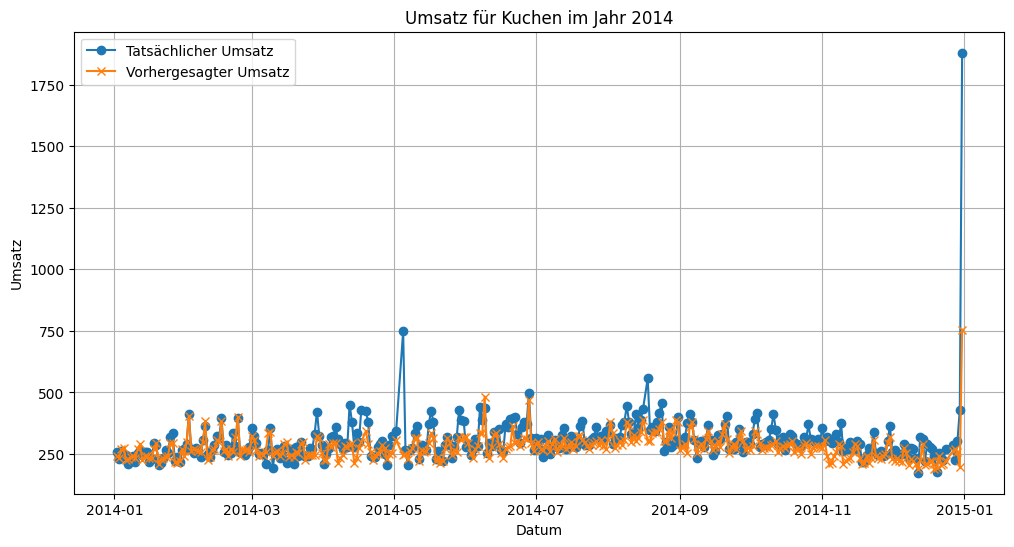

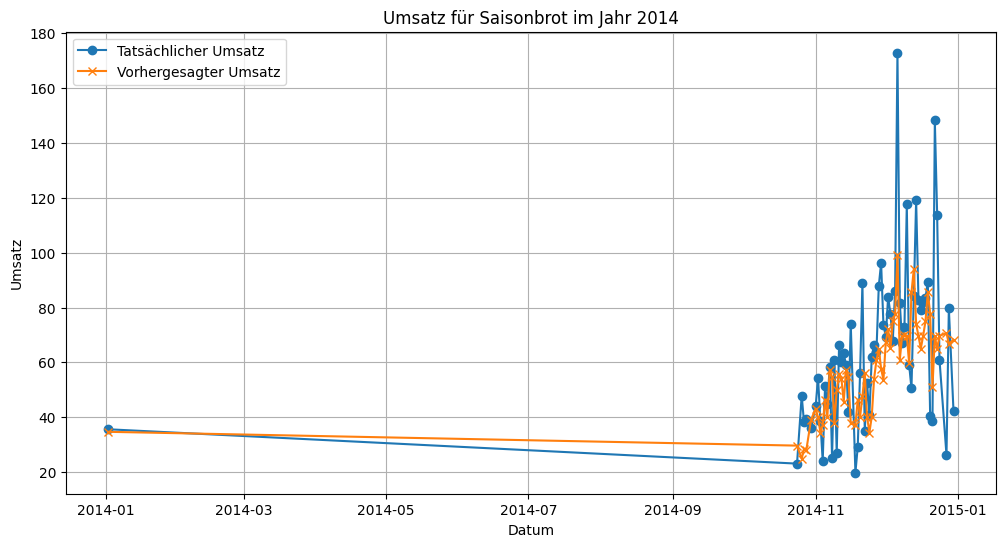

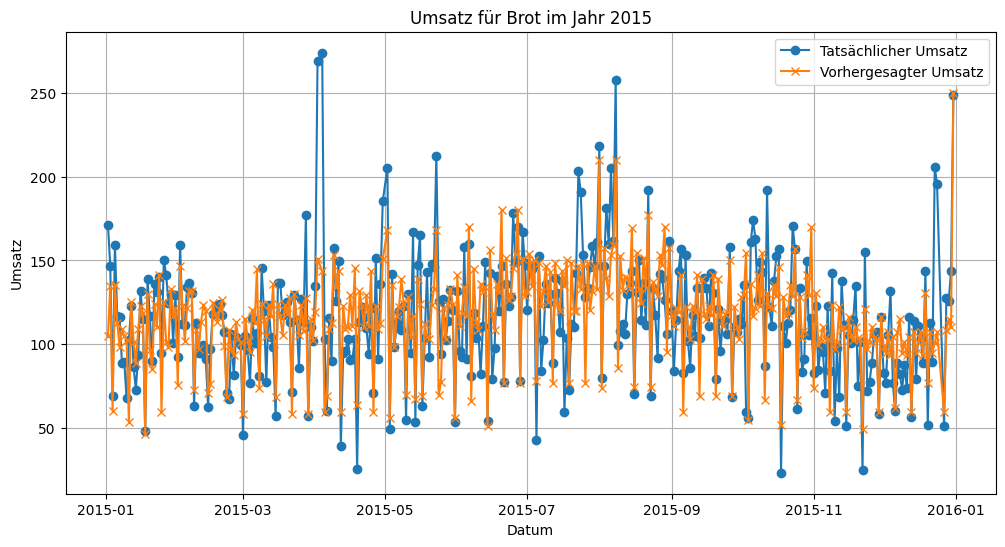

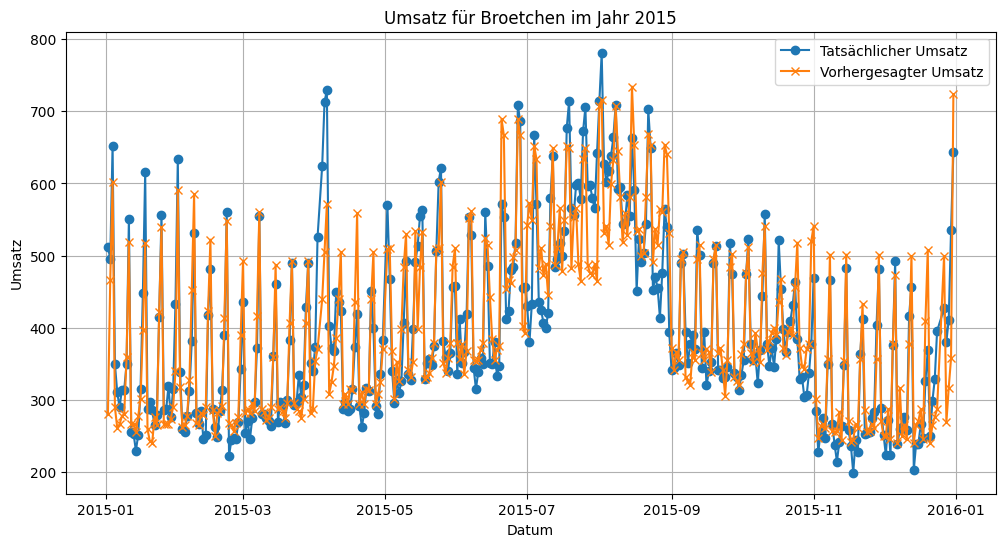

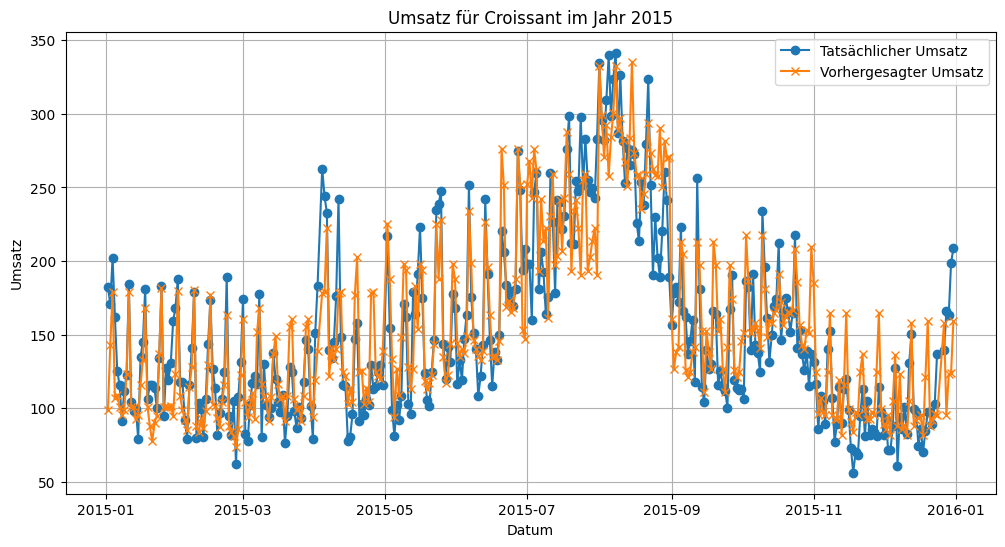

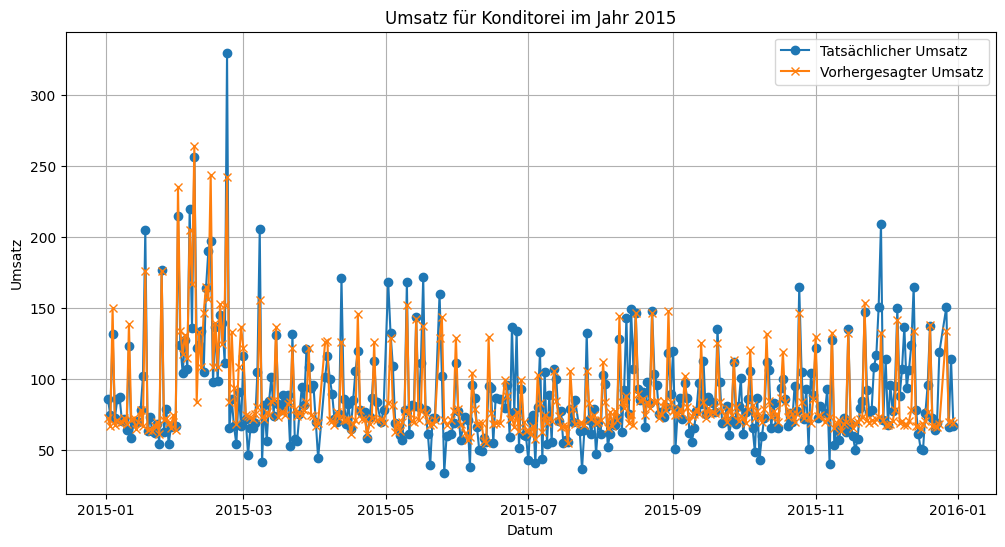

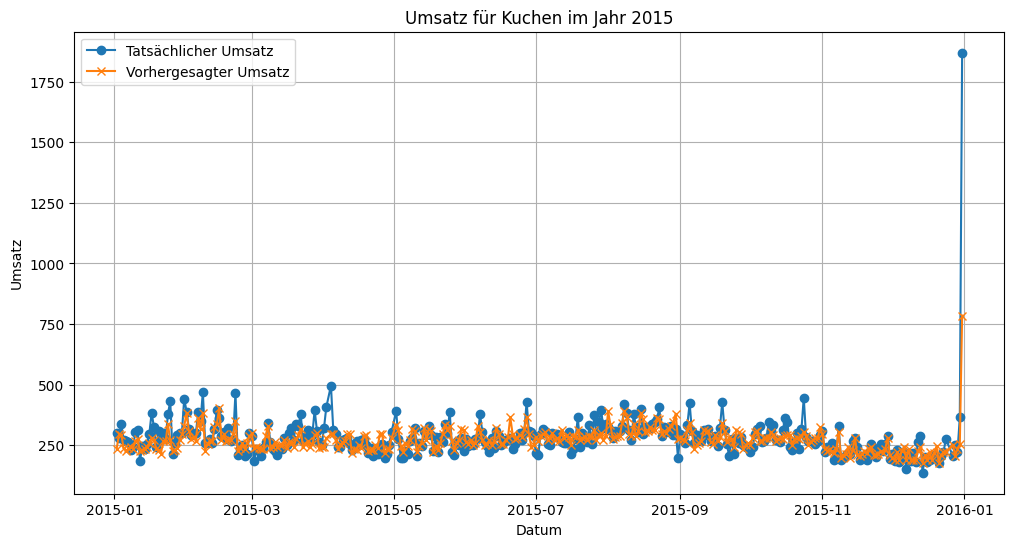

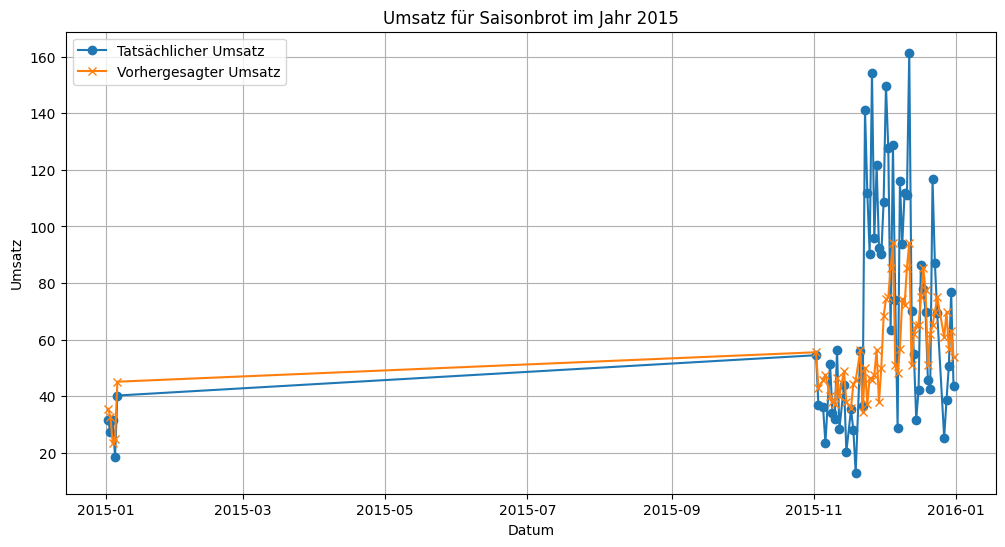

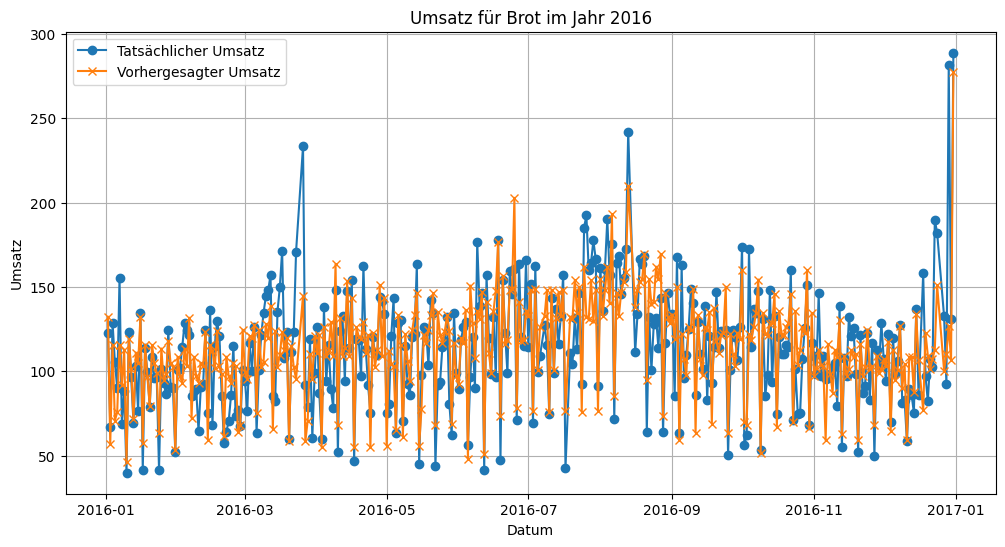

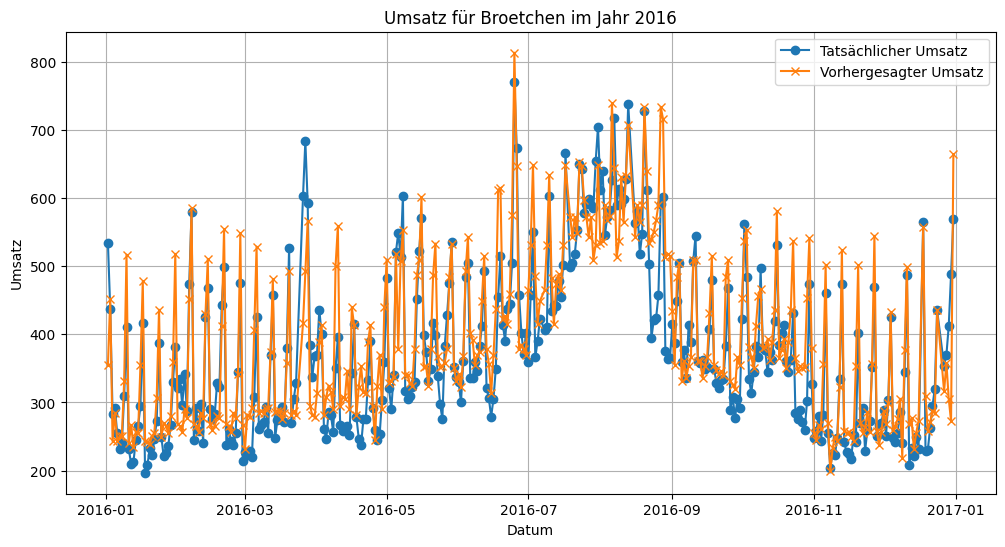

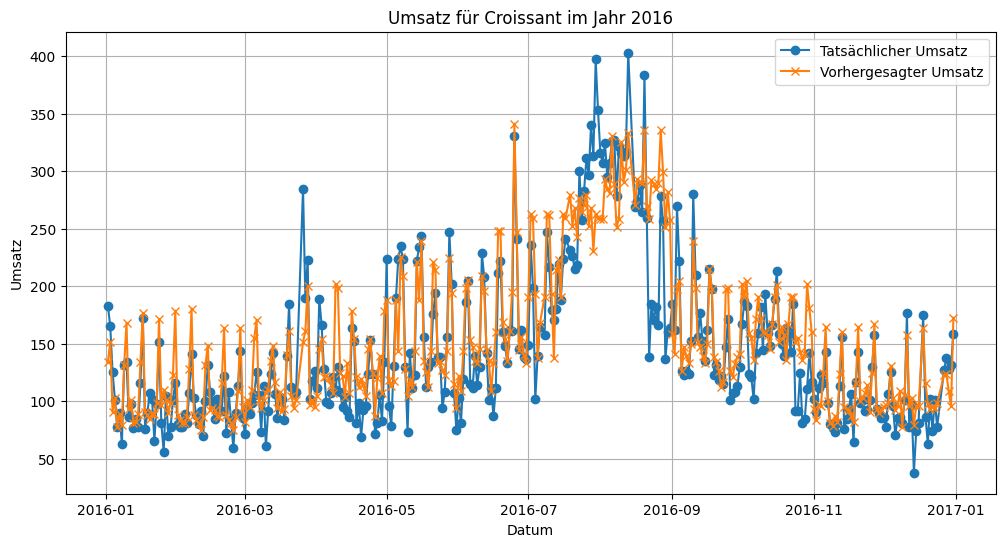

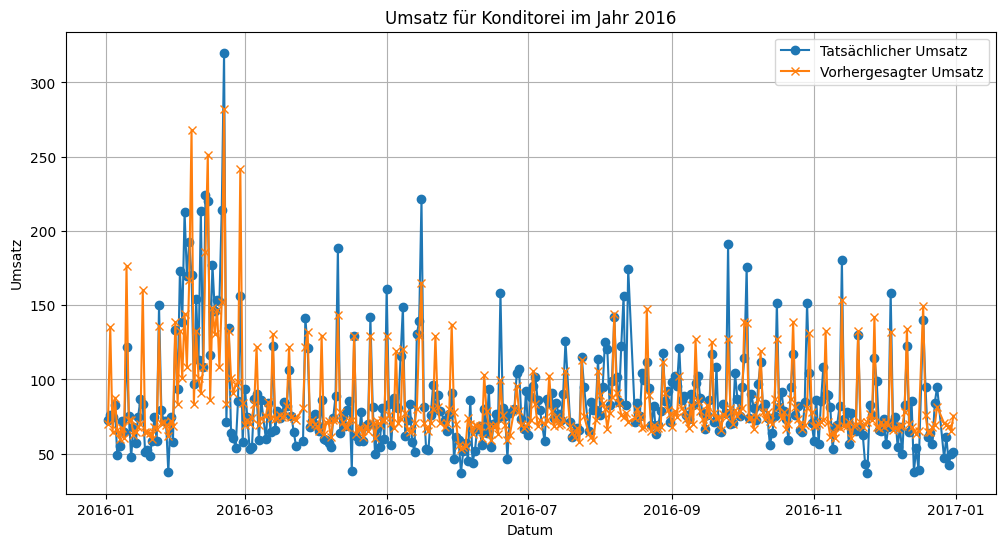

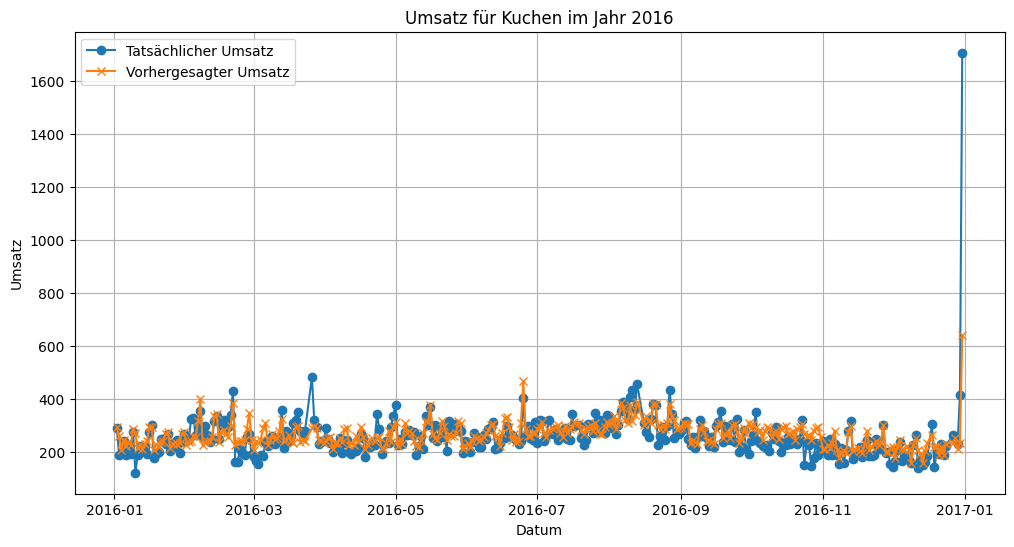

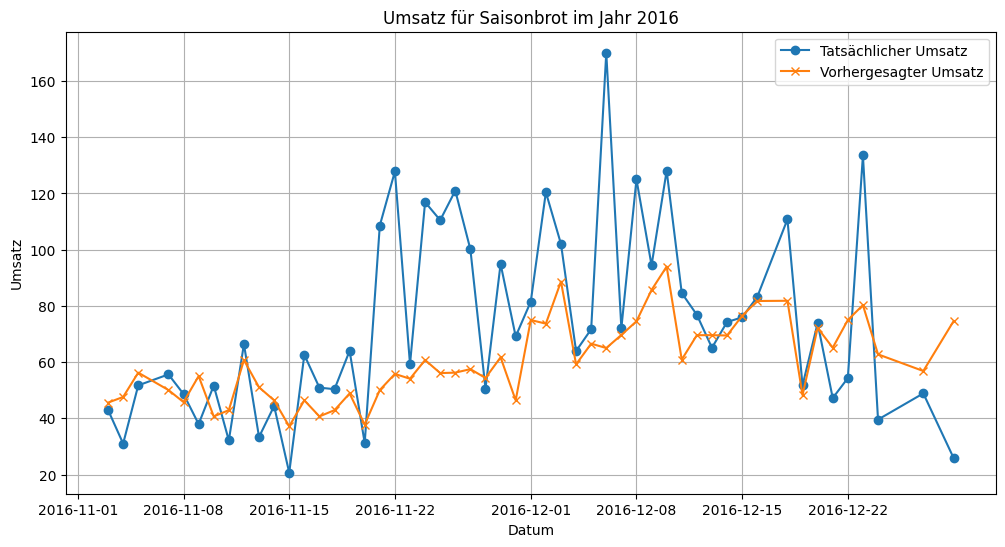

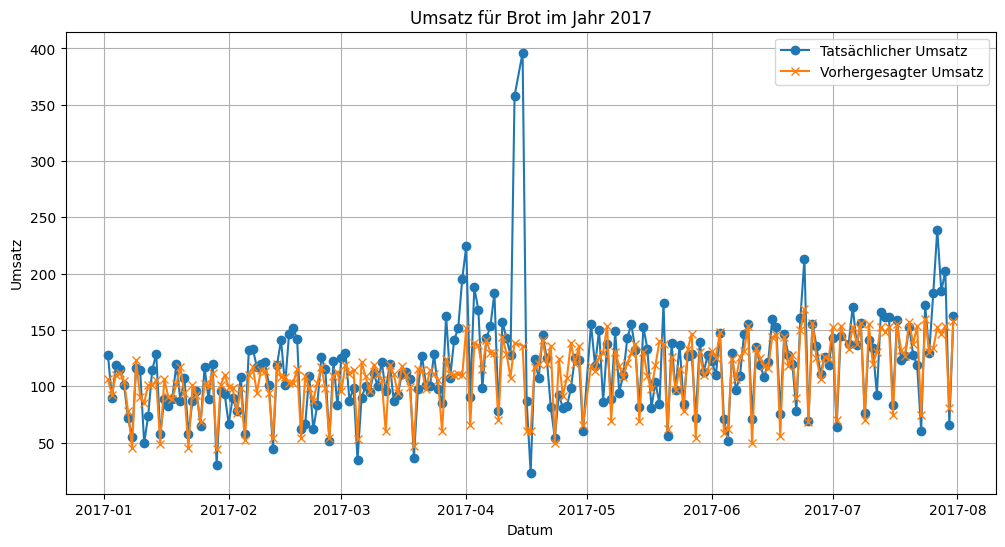

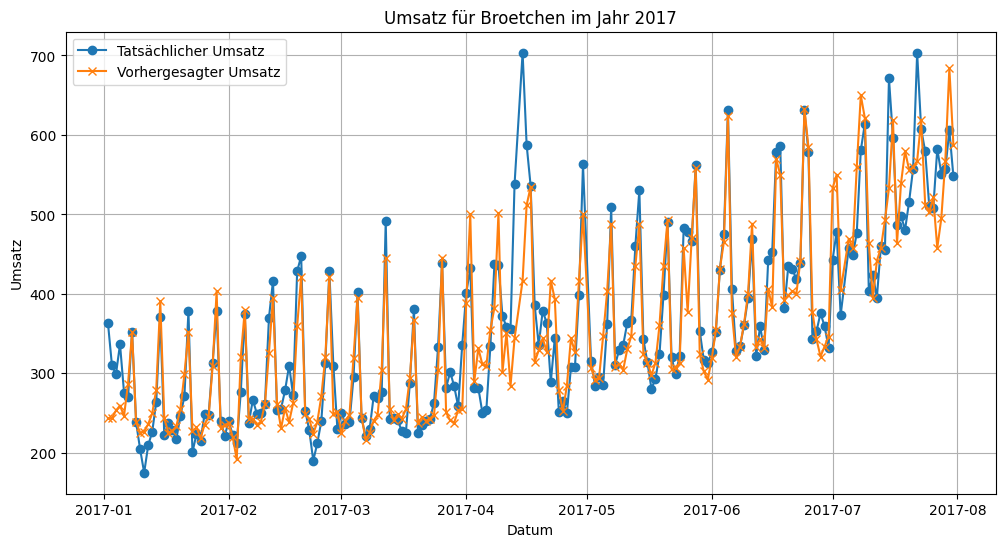

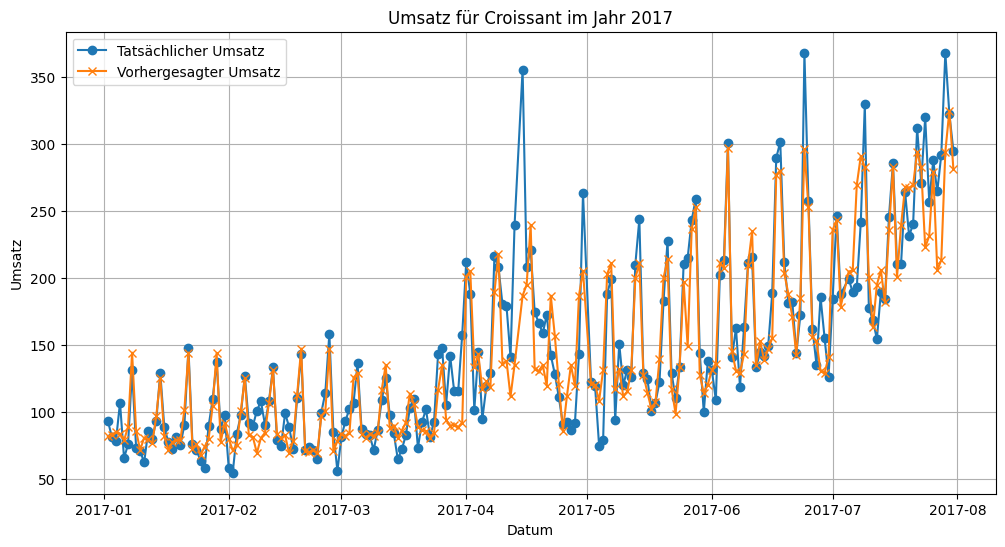

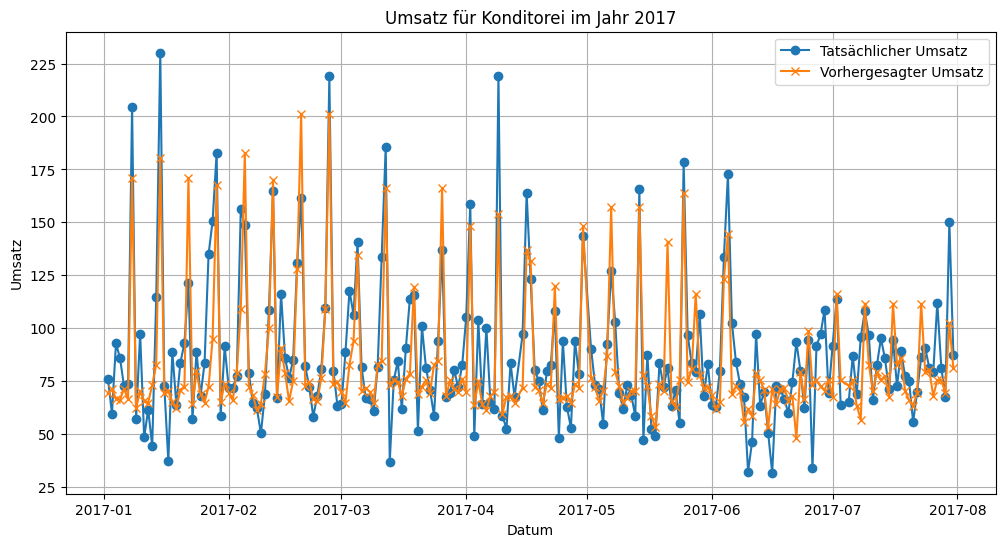

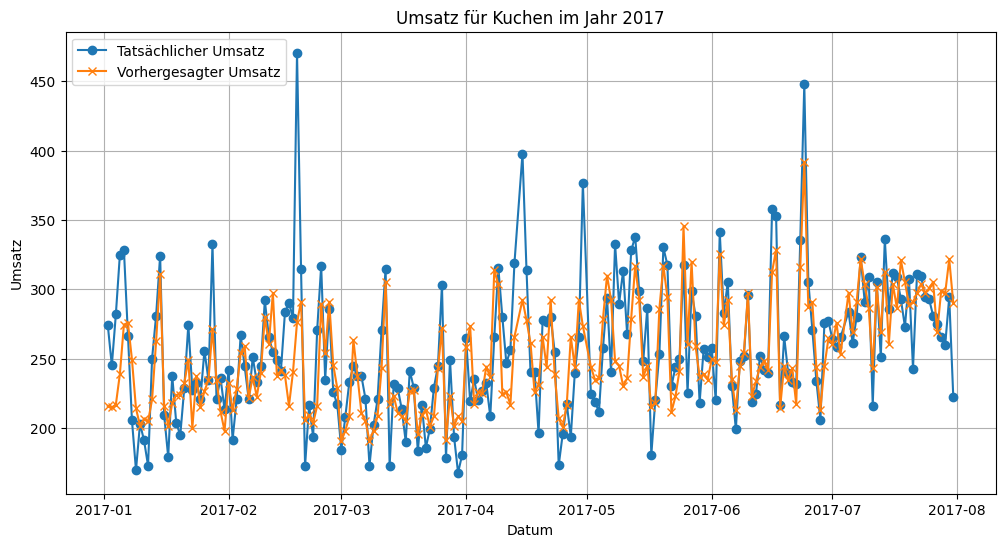

In [21]:
plot_yearly_sales(train_predictions_df)

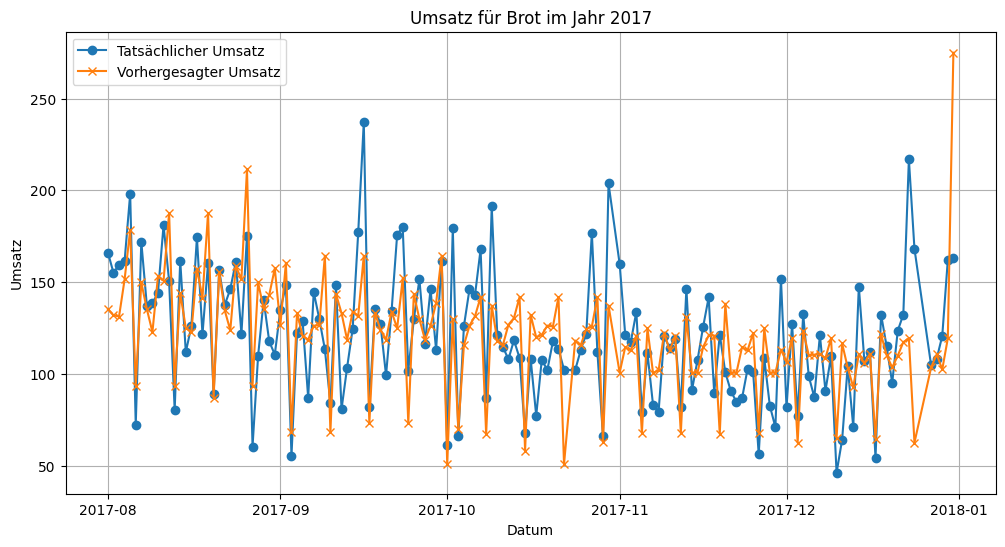

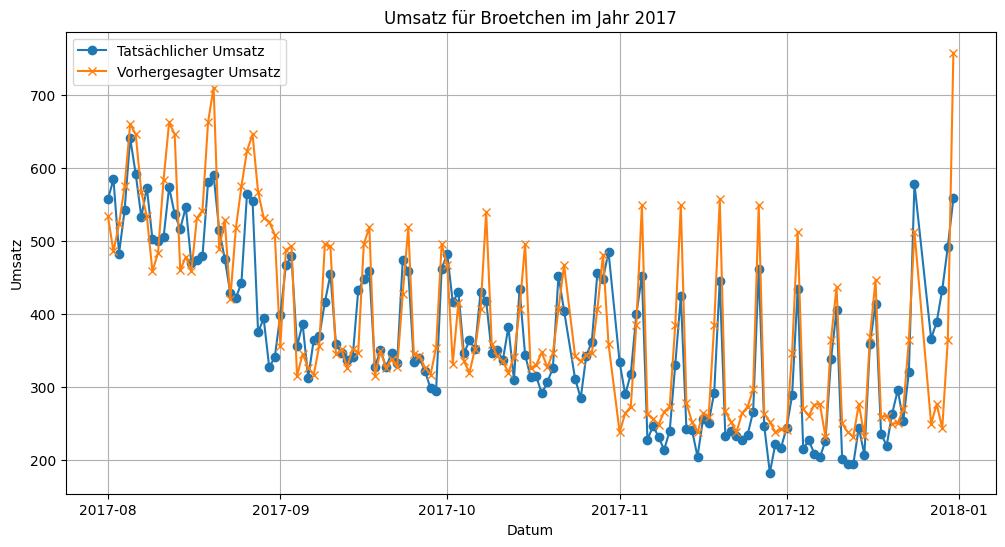

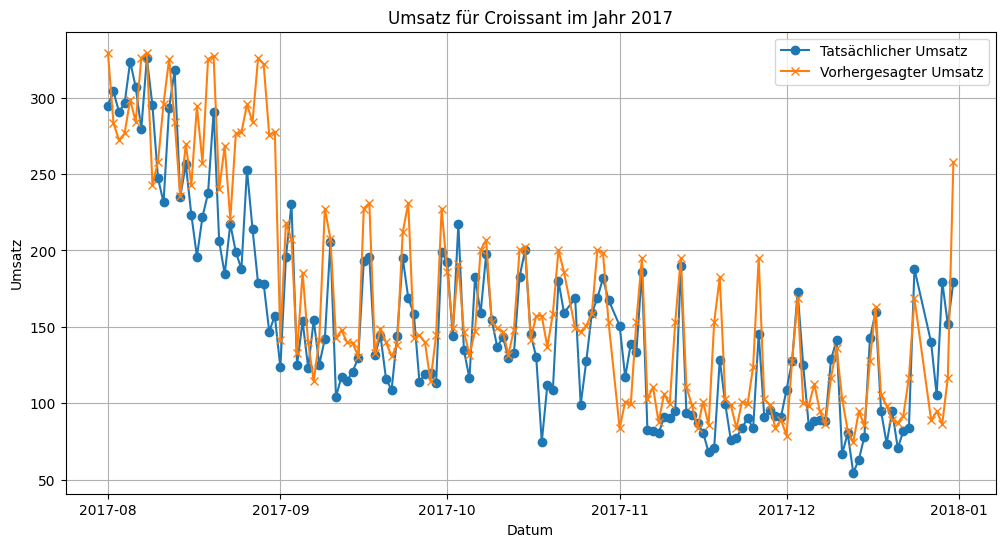

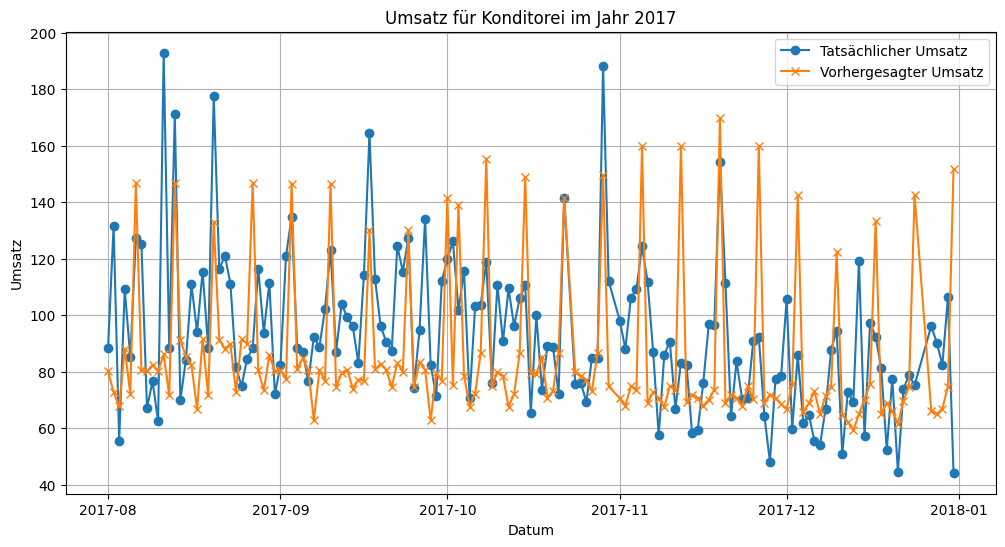

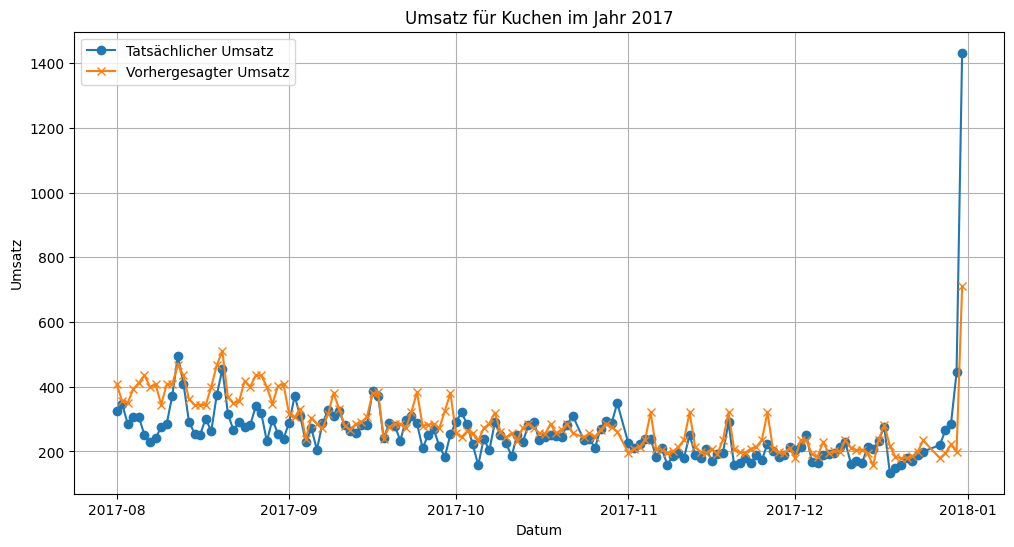

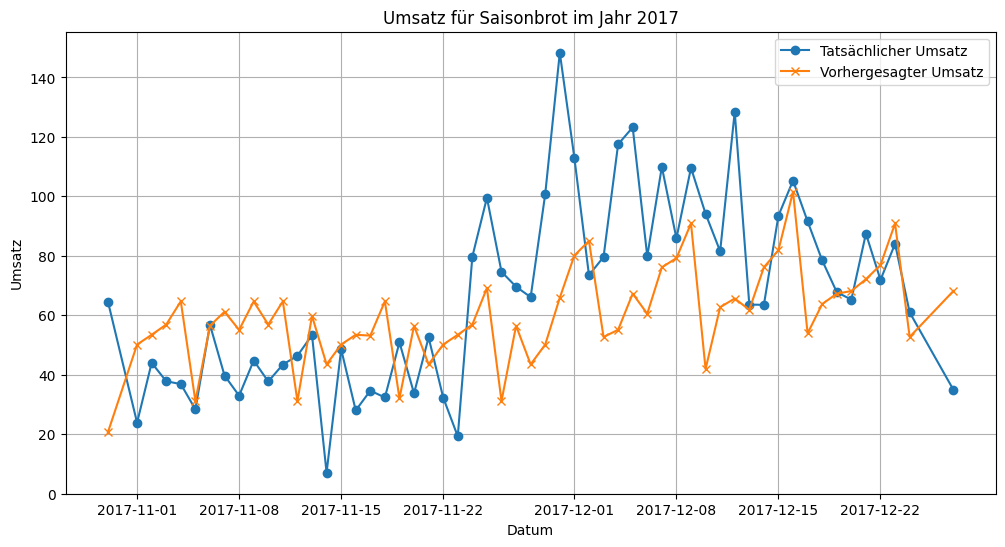

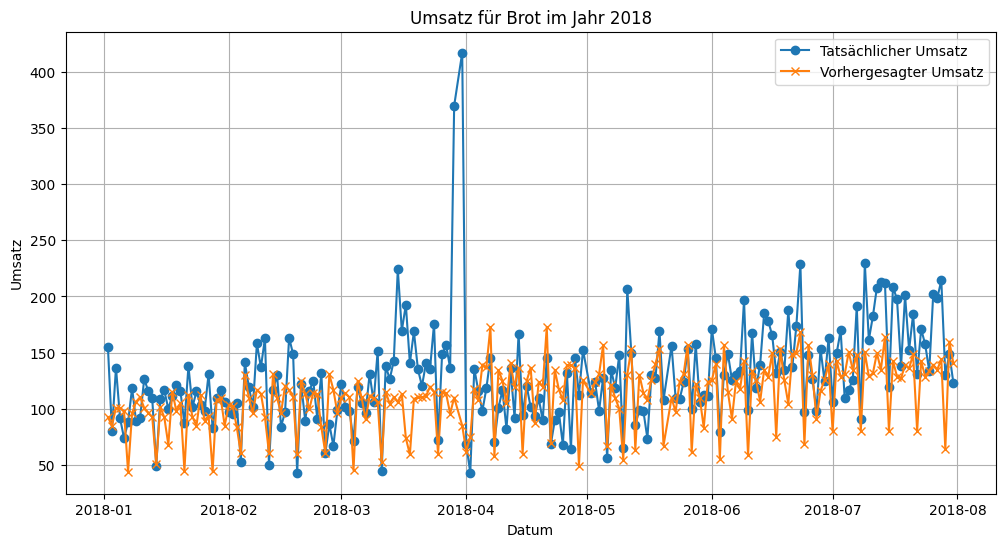

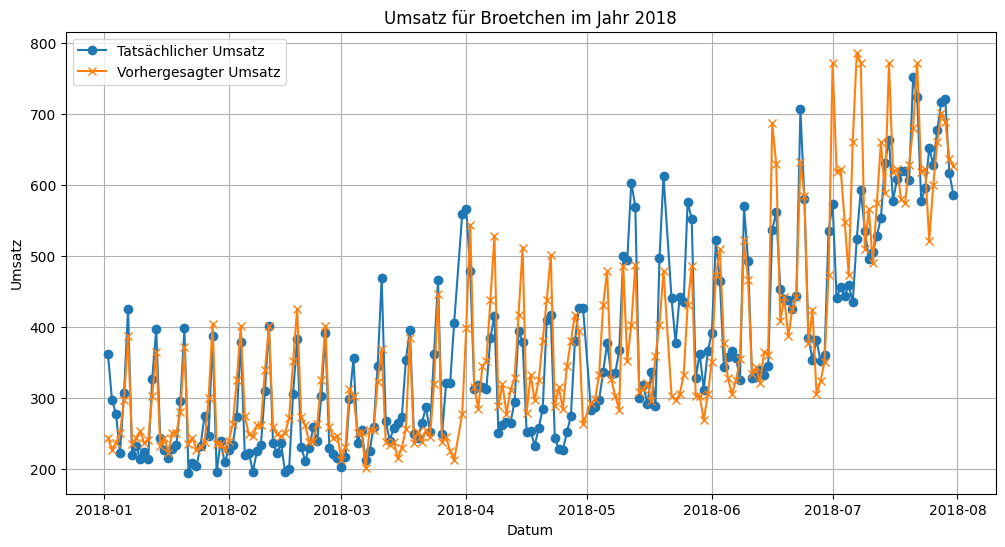

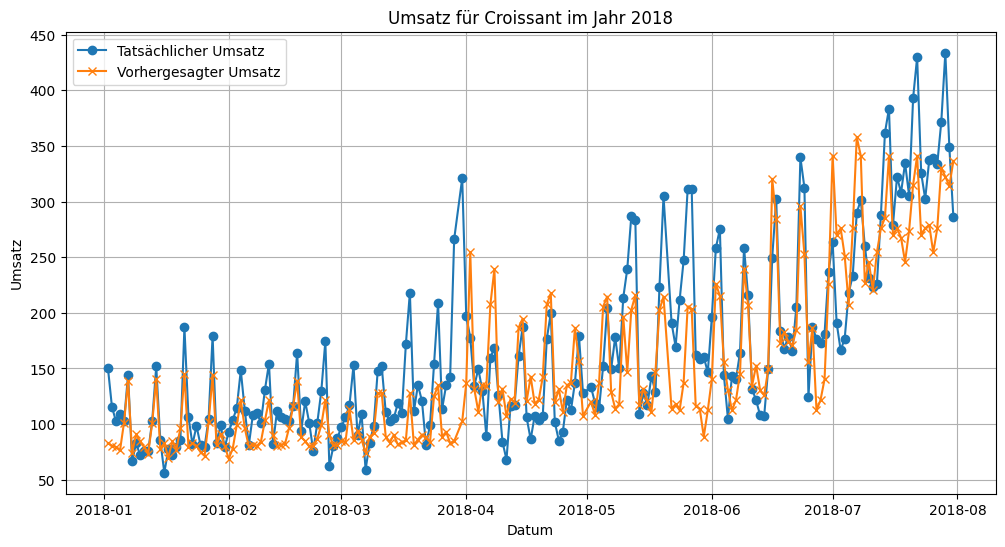

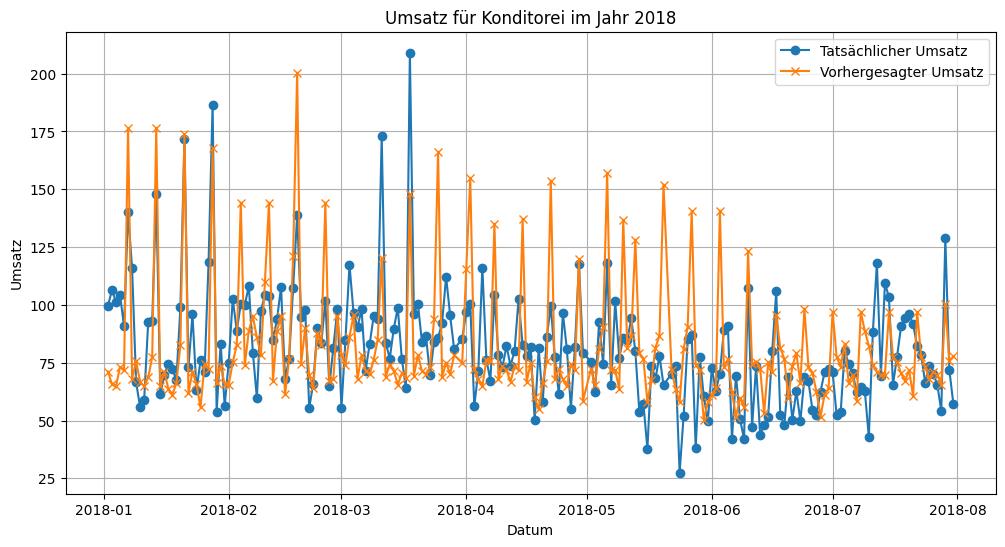

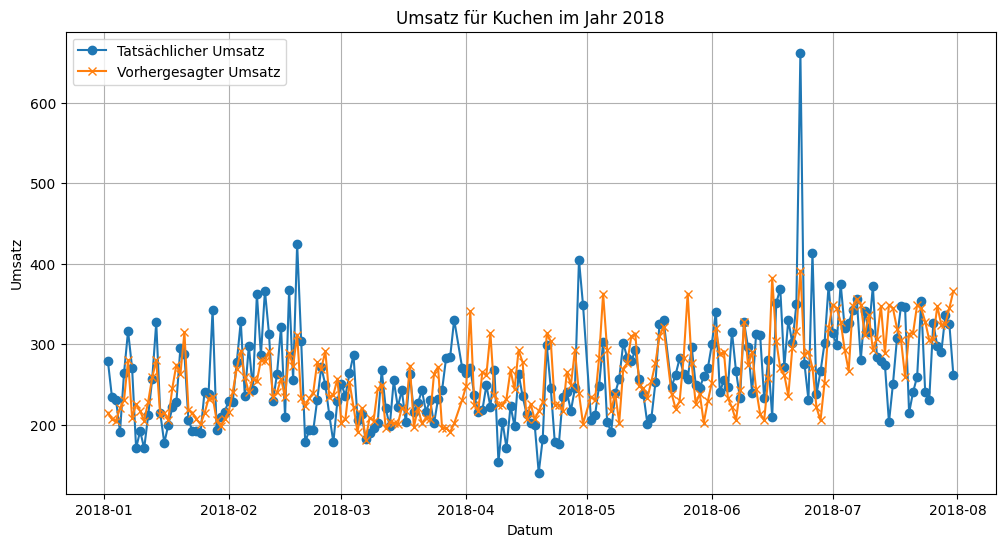

In [22]:
plot_yearly_sales(val_predictions_df)